In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Envs import register
import gymnasium as gym
from stable_baselines3 import PPO
from vis_model import aggregate_eval, plot_eval, plot_multiple_eval, plotly_vector_field, visualize_plotly_model
import plotly.express as px

pybullet build time: Oct  3 2024 08:55:45


In [13]:
model_path = "../checkpoints/StaticWaypointEnv/SingleWaypointNavigation/AfterTune/best_model"
env_id = "SingleWaypointQuadXEnv-v0"

render = False
num_eval_eps = 10
env = gym.make(env_id, render_mode="human" if render else None)
_ = env.reset()
model = PPO.load(model_path, deterministic=True)

/Users/felixunterleiter/Documents/GitHub/pyflyt_experience/venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning:

Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18

/Users/felixunterleiter/Documents/GitHub/pyflyt_experience/venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning:

Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18



In [14]:
result = aggregate_eval(model, env, num_eval_eps, render=False, include_waypoints=True)

/Users/felixunterleiter/Documents/GitHub/pyflyt_experience/Evaluation/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



# Visualizing Trajectory and Waypoints

In [15]:
# Visualizing 'n_eval_eps' episodes as sampled from the trained model
visualize_plotly_model(result, model, env, num_eval_eps)

# Trajectory with vector field

In [27]:
ep_idx = 5
linear_positions = result["linear_position"][ep_idx]
linear_velocities = result["linear_velocity"][ep_idx]
target_vector = result["waypoints"][ep_idx]
plotly_vector_field(linear_positions, linear_velocities, target_vector, size=0.2)

# Smoothness of control inputs

/Users/felixunterleiter/Documents/GitHub/pyflyt_experience/Evaluation/vis_model.py:126: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



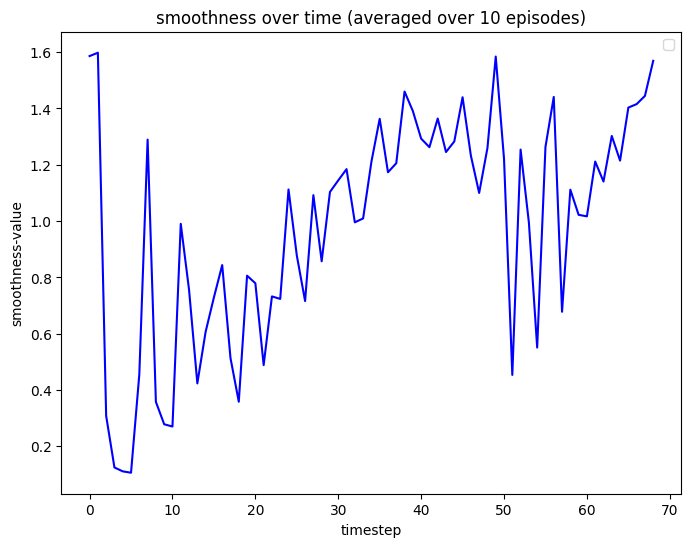

In [17]:
smoothness_result = {
    "smoothness": result["smoothness"]
}
plot_eval(smoothness_result, average=True)

# Azimuth and Elevation Angles

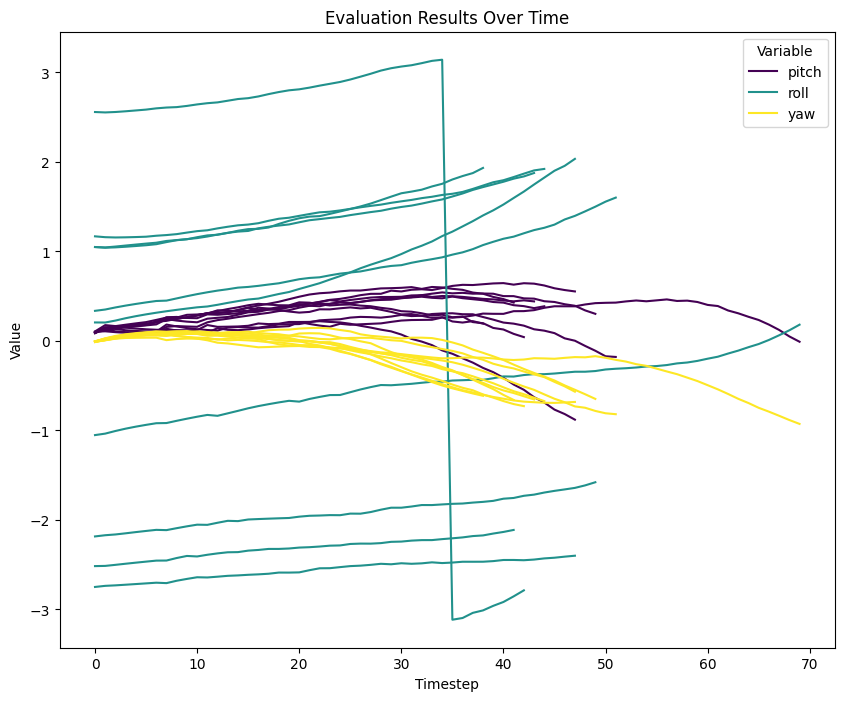

In [23]:
pitch, yaw, roll = [[np.array([a[0]]) for a in result["angular_position"][0]]], [[np.array([a[1]]) for a in result["angular_position"][0]]], [[np.array([a[2]]) for a in result["angular_position"][0]]]

angles_result = {
    # "azimuth": result["azimuth_angle"],
    # "elevation": result["elevation_angle"],
    "pitch": result["pitch"],
    "roll": result["roll"],
    "yaw": result["yaw"],
    # "thrust": result["thrust"]
}

plot_multiple_eval(angles_result, average=False)

# Translation Accuracy

The translation accuracy describes the absolute difference between the sampled action and its effect on the angular position of the UAV.

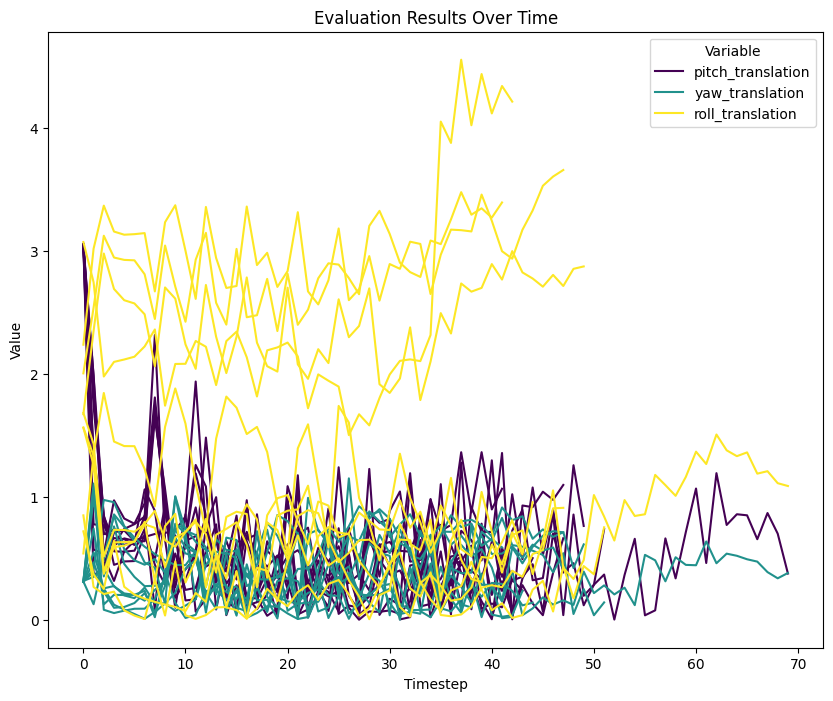

In [19]:
pitch_transl, yaw_transl, roll_transl = [], [], []

for ep in result["translation_accuracy"]:
    pitch_transl.append([np.array([a[0]]) for a in ep])
    yaw_transl.append([np.array([a[1]]) for a in ep])
    roll_transl.append([np.array([a[2]]) for a in ep])
    
translation_result = {
    "pitch_translation": pitch_transl,
    "yaw_translation": yaw_transl,
    "roll_translation": roll_transl
}

plot_multiple_eval(translation_result, average=False)

# Angular Positions over time

In [20]:
abs_max_pitch, abs_max_roll, abs_max_yaw = -np.inf, -np.inf, -np.inf
abs_min_pitch, abs_min_roll, abs_min_yaw = np.inf, np.inf, np.inf

for ep in result["angular_position"]:
    # Plot the maximum angular position for each episode
    max_pitch, max_roll, max_yaw = np.max(np.abs(ep), axis=0)
    min_pitch, min_roll, min_yaw = np.min(np.abs(ep), axis=0)
    if max_pitch > abs_max_pitch:
        abs_max_pitch = max_pitch
    if max_roll > abs_max_roll:
        abs_max_roll = max_roll
    if max_yaw > abs_max_yaw:
        abs_max_yaw = max_yaw
        
    if min_pitch < abs_min_pitch:
        abs_min_pitch = min_pitch
    if min_roll < abs_min_roll:
        abs_min_roll = min_roll
    if min_yaw < abs_min_yaw:
        abs_min_yaw = min_yaw
    
print(f"Max Pitch: {abs_max_pitch}, Max Roll: {abs_max_roll}, Max Yaw: {abs_max_yaw}")
print(f"Min Pitch: {abs_min_pitch}, Min Roll: {abs_min_roll}, Min Yaw: {abs_min_yaw}")

Max Pitch: 0.8799984351545296, Max Roll: 0.9275107143396802, Max Yaw: 3.1415301220341196
Min Pitch: 0.001993230034401808, Min Roll: 3.589149765697043e-05, Min Yaw: 0.0105317908191825


# Experimentation

In [21]:
env_id = "SingleWaypointQuadXEnv-v0"
env = gym.make(env_id, render_mode=None)

term, trunc = False, False
obs, info = env.reset()
target_vector = env.unwrapped.waypoints.targets[0]
print(f'Target vector: {target_vector}')

linear_positions = []
linear_velocities = []  # in unit-length
t = 0
sign = 1

while not (term or trunc):
    action = env.action_space.sample()
    print(f'Action: {action}')
    obs, reward, term, trunc, info = env.step(action)
    linear_positions.append(info["linear_position"])
    # linear_velocities.append(info["linear_velocity"]/np.linalg.norm(info["linear_velocity"]))
    lin_vel = info["linear_velocity"]
    # lin_vel[2] = 0.0
    linear_velocities.append(lin_vel)
    lin_vel_xy_proj = info["linear_velocity"][:2]/np.linalg.norm(info["linear_velocity"][:2])
    LOS_vector = target_vector - info["linear_position"]
    LOS_xy_proj = LOS_vector[:2]/np.linalg.norm(LOS_vector[:2])
    print(f'(t={t}): velocity: {lin_vel_xy_proj}; LOS: {LOS_xy_proj}; azimuth: {obs["azimuth_angle"]}; elevation: {obs["elevation_angle"]}')
    # print(f'(t={t}): Current angular position: {info["angular_position"]}')
    # print(f'(t={t}): Current angular velocity: {obs["ang_vel"]}')
    # if np.abs(info["angular_position"][0]) >= 1.0*np.pi:
    #     print("---- Angular position exceeded threshold ----")
    #     sign *= -1
    t += 1

                             
                             
Target vector: [-3.36439714e-03 -6.05263682e-02  8.50000000e+00]
Action: [-0.83070214  1.09685168  2.54025059  0.57715687]
(t=0): velocity: [0.80906111 0.58772453]; LOS: [-0.05663851 -0.99839475]; azimuth: [2.25570864]; elevation: [-3.13072069]
Action: [-1.76597824  1.05239927  3.08418987  0.57812232]
(t=1): velocity: [0.78000796 0.6257696 ]; LOS: [-0.07050316 -0.99751156]; azimuth: [2.31747582]; elevation: [-2.53536853]
Action: [ 2.79503723  1.92421004 -0.52880711  0.64509445]
(t=2): velocity: [0.79332155 0.60880285]; LOS: [-0.11222114 -0.99368326]; azimuth: [2.33780503]; elevation: [-0.22766041]
Action: [-2.11015029 -1.76399597 -2.96685671  0.59662042]
(t=3): velocity: [0.8856212  0.46440833]; LOS: [-0.19673388 -0.98045692]; azimuth: [2.25178832]; elevation: [-0.2148118]
Action: [-0.05473251  2.78301222  3.05930785  0.76745447]
(t=4): velocity: [0.85082334 0.52545185]; LOS: [-0.30202826 -0.95329897]; azimuth: [2.43086198]; e